In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from traffic.core import Traffic

from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from matplotlib import pyplot as plt
from datetime import datetime

from functions.data_filtering import complete_flight_filter, filter_flights, filter_by_bools
from functions.data_processing import get_takeoff_and_landing_directions
from functions.data_loading import get_filtered_data_range

device = (torch.device('cuda')
          if torch.cuda.is_available()
          else torch.device('cpu'))

In [2]:
origin = "bergen"
destination = "oslo"
filtered_flights: Traffic = get_filtered_data_range(origin, destination, datetime(year=2023, month=1, day=1), datetime(year=2024, month=1, day=1), complete_flight_filter(origin, destination))

In [3]:
directions = list(get_takeoff_and_landing_directions(filtered_flights))
dataset = pd.DataFrame(directions)
dataset.rename({0: "start_time",  1: "end_time", 2: "start_direction", 3: "end_direction"}, axis=1, inplace=True)
dataset['start_x'], dataset['start_y']  = np.sin(dataset['start_direction']), np.cos(dataset['start_direction'])
dataset['end_x'], dataset['end_y'] = np.sin(dataset['end_direction']), np.cos(dataset['end_direction'])
dataset['start_time'] = pd.to_datetime(dataset['start_time']).dt.round("s")
dataset['end_time'] = pd.to_datetime(dataset['end_time']).dt.round("s")

In [4]:
dataset

,start_time,end_time,start_direction,end_direction,start_x,start_y,end_x,end_y
0,2023-02-07 20:44:04+00:00,2023-02-07 21:30:00+00:00,2.936878,3.423365,0.203288,-0.979119,-0.278058,-0.960564
1,2023-06-21 04:15:14+00:00,2023-06-21 04:50:10+00:00,2.968032,0.270153,0.172691,-0.984976,0.266879,0.963730
2,2023-06-25 07:02:26+00:00,2023-06-25 07:36:04+00:00,2.968032,3.425084,0.172691,-0.984976,-0.279710,-0.960085
3,2023-03-04 08:21:18+00:00,2023-03-04 08:55:38+00:00,6.125815,0.275272,-0.156721,0.987643,0.271809,0.962351
4,2023-11-29 08:38:32+00:00,2023-11-29 09:18:40+00:00,6.108513,0.276035,-0.173785,0.984784,0.272543,0.962144
...,...,...,...,...,...,...,...,...
3214,2023-09-03 16:10:32+00:00,2023-09-03 16:44:30+00:00,2.984176,3.422004,0.156768,-0.987636,-0.276751,-0.960942
3215,2023-06-25 09:23:36+00:00,2023-06-25 09:58:28+00:00,2.969402,3.421892,0.171341,-0.985212,-0.276644,-0.960973
3216,2023-10-28 14:57:24+00:00,2023-10-28 15:33:56+00:00,2.978186,0.290734,0.162680,-0.986679,0.286656,0.958034
3217,2023-06-22 08:11:52+00:00,2023-06-22 08:47:14+00:00,2.968170,3.421892,0.172555,-0.985000,-0.276644,-0.960973


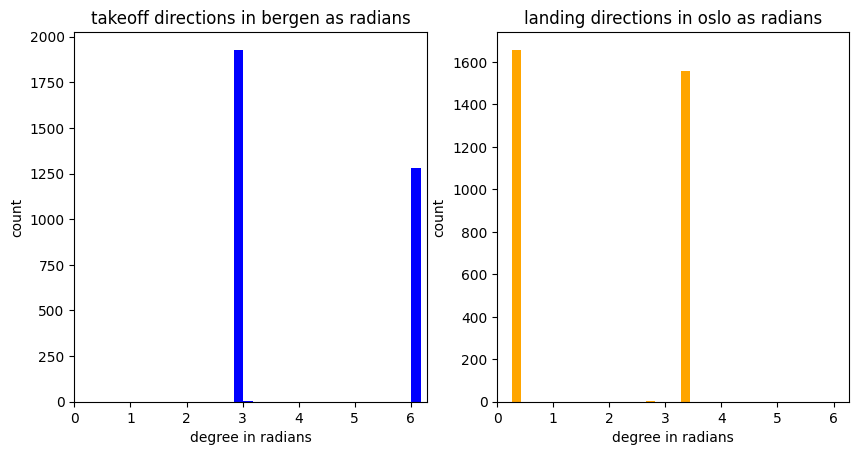

In [5]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(dataset['start_direction'], bins=20, color="blue")
ax[0].set_xlim([0, 2*np.pi])
ax[0].set_title(f"takeoff directions in {origin} as radians")
ax[0].set_xlabel('degree in radians')
ax[0].set_ylabel('count')

ax[1].hist(dataset['end_direction'], bins=20, color="orange")
ax[1].set_xlim([0, 2*np.pi])
ax[1].set_title(f"landing directions in {destination} as radians")
ax[1].set_xlabel('degree in radians')
ax[1].set_ylabel('count')
fig.set_figwidth(10)
plt.show()

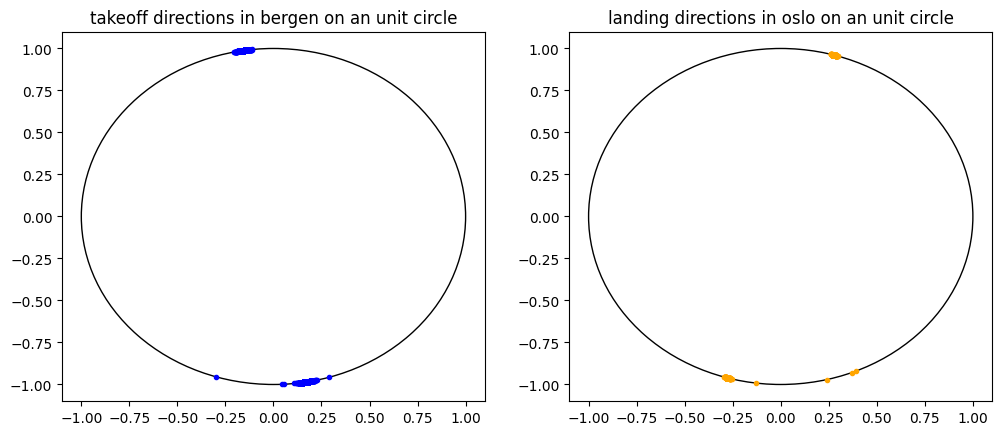

In [6]:
fig, ax = plt.subplots(ncols=2, )
ax: plt.Subplot

circle = plt.Circle((0, 0), 1, fill=False)
ax[0].add_patch(circle)
ax[0].plot(dataset["start_x"], dataset["start_y"], '.', color="blue")
ax[0].set_xlim([-1.1, 1.1])
ax[0].set_ylim([-1.1, 1.1])
ax[0].set_title(f"takeoff directions in {origin} on an unit circle")

circle = plt.Circle((0, 0), 1, fill=False)
ax[1].add_patch(circle)
ax[1].plot(dataset["end_x"], dataset["end_y"], '.', color="orange")
ax[1].set_xlim([-1.1, 1.1])
ax[1].set_ylim([-1.1, 1.1])
ax[1].set_title(f"landing directions in {destination} on an unit circle")

fig.set_figwidth(12)
plt.show()

In [7]:
model = DBSCAN()
clustering = model.fit(dataset[['start_x', 'start_y', 'end_x', 'end_y']])

set(clustering.labels_)

{-1, 0, 1, 2, 3}

In [8]:
labels = pd.DataFrame(clustering.labels_, columns=["cluster"])
labeled_dataset = pd.concat([dataset, labels], axis=1)

In [9]:
labeled_dataset

,start_time,end_time,start_direction,end_direction,start_x,start_y,end_x,end_y,cluster
0,2023-02-07 20:44:04+00:00,2023-02-07 21:30:00+00:00,2.936878,3.423365,0.203288,-0.979119,-0.278058,-0.960564,0
1,2023-06-21 04:15:14+00:00,2023-06-21 04:50:10+00:00,2.968032,0.270153,0.172691,-0.984976,0.266879,0.963730,1
2,2023-06-25 07:02:26+00:00,2023-06-25 07:36:04+00:00,2.968032,3.425084,0.172691,-0.984976,-0.279710,-0.960085,0
3,2023-03-04 08:21:18+00:00,2023-03-04 08:55:38+00:00,6.125815,0.275272,-0.156721,0.987643,0.271809,0.962351,2
4,2023-11-29 08:38:32+00:00,2023-11-29 09:18:40+00:00,6.108513,0.276035,-0.173785,0.984784,0.272543,0.962144,2
...,...,...,...,...,...,...,...,...,...
3214,2023-09-03 16:10:32+00:00,2023-09-03 16:44:30+00:00,2.984176,3.422004,0.156768,-0.987636,-0.276751,-0.960942,0
3215,2023-06-25 09:23:36+00:00,2023-06-25 09:58:28+00:00,2.969402,3.421892,0.171341,-0.985212,-0.276644,-0.960973,0
3216,2023-10-28 14:57:24+00:00,2023-10-28 15:33:56+00:00,2.978186,0.290734,0.162680,-0.986679,0.286656,0.958034,1
3217,2023-06-22 08:11:52+00:00,2023-06-22 08:47:14+00:00,2.968170,3.421892,0.172555,-0.985000,-0.276644,-0.960973,0


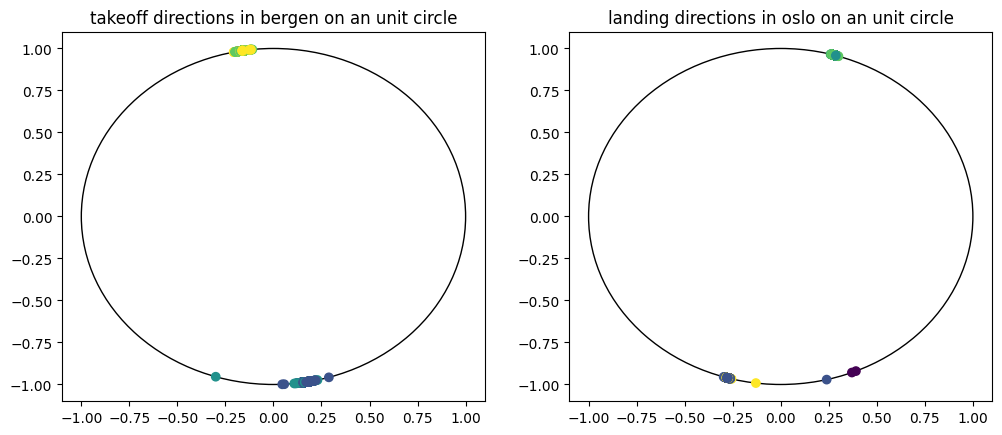

In [10]:
fig, ax = plt.subplots(ncols=2, )
ax: plt.Subplot

circle = plt.Circle((0, 0), 1, fill=False)
ax[0].add_patch(circle)
ax[0].scatter(labeled_dataset['start_x'], labeled_dataset['start_y'], c=labeled_dataset['cluster'])
ax[0].set_xlim([-1.1, 1.1])
ax[0].set_ylim([-1.1, 1.1])
ax[0].set_title(f"takeoff directions in {origin} on an unit circle")

circle = plt.Circle((0, 0), 1, fill=False)
ax[1].add_patch(circle)
ax[1].scatter(labeled_dataset['end_x'], labeled_dataset['end_y'], c=labeled_dataset['cluster'])
ax[1].set_xlim([-1.1, 1.1])
ax[1].set_ylim([-1.1, 1.1])
ax[1].set_title(f"landing directions in {destination} on an unit circle")

fig.set_figwidth(12)
plt.show()

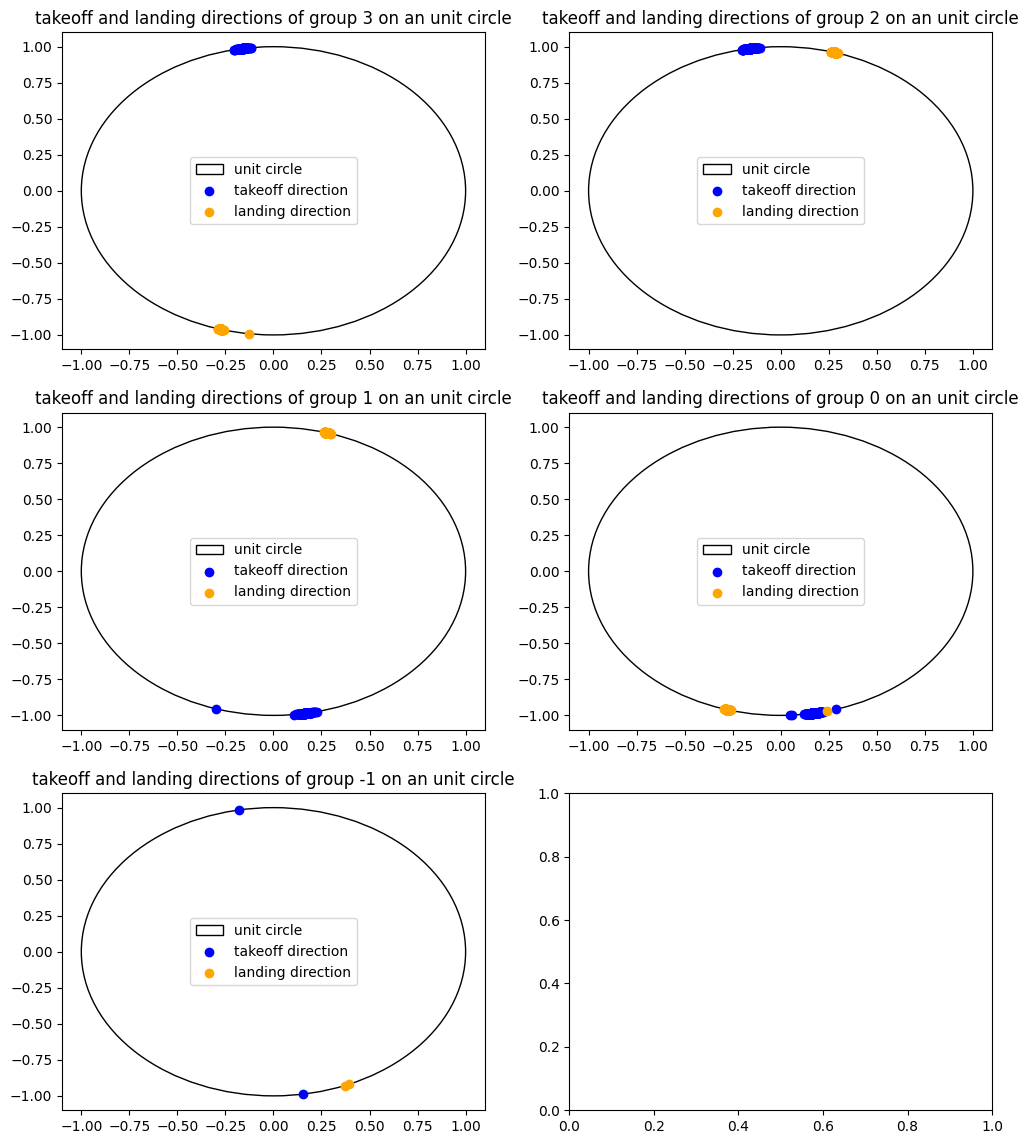

In [11]:
fig, ax = plt.subplots(3, 2)
locs = {3: (0, 0), 2: (0, 1), 1: (1, 0), 0: (1, 1), -1: (2, 0)}
for i in range(3, -2, -1):
    y, x = locs[i]
    filtered_by_label = labeled_dataset.loc[labeled_dataset['cluster'] == i]
    
    circle = plt.Circle((0, 0), 1, fill=False)
    ax[y, x].add_patch(circle)
    ax[y, x].scatter(filtered_by_label['start_x'], filtered_by_label['start_y'], c='blue')
    ax[y, x].scatter(filtered_by_label['end_x'], filtered_by_label['end_y'], c='orange')
    ax[y, x].legend(["unit circle","takeoff direction", "landing direction"])
    ax[y, x].set_xlim([-1.1, 1.1])
    ax[y, x].set_ylim([-1.1, 1.1])
    ax[y, x].set_title(f"takeoff and landing directions of group {i} on an unit circle")
    
    fig.set_figwidth(12)
    fig.set_figheight(14)
plt.show()

In [12]:
cluster_0 = filter_flights(filter_by_bools(labeled_dataset['cluster'] == 0), filtered_flights)
cluster_1 = filter_flights(filter_by_bools(labeled_dataset['cluster'] == 1), filtered_flights)
cluster_2 = filter_flights(filter_by_bools(labeled_dataset['cluster'] == 2), filtered_flights)
cluster_3 = filter_flights(filter_by_bools(labeled_dataset['cluster'] == 3), filtered_flights)
cluster_outliar = filter_flights(filter_by_bools(labeled_dataset['cluster'] == -1), filtered_flights)

In [13]:
#cluster_0.map_leaflet()

Map(center=[60.371877259039934, 8.554712260358537], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [14]:
#cluster_1.map_leaflet()


In [15]:
#cluster_2.map_leaflet()

In [16]:
#cluster_3.map_leaflet()

In [17]:
#cluster_outliar.map_leaflet()

#### some times the flights dont match up with the cluster hmm

In [18]:
from functions.data_processing import prepare_wind_data
from functions.data_loading import get_wind_direction

gardermoen = get_wind_direction("GARDERMOEN")
wind_data = prepare_wind_data(gardermoen)

In [19]:
wind_data

,wind_direction,wind_speed,x,y
time,,,,
2023-01-01 00:00:00+00:00,0.750492,1.200000,0.818398,0.877624
2023-01-01 00:00:01+00:00,0.749575,1.201167,0.818388,0.879228
2023-01-01 00:00:02+00:00,0.748659,1.202333,0.818377,0.880832
2023-01-01 00:00:03+00:00,0.747743,1.203500,0.818362,0.882437
2023-01-01 00:00:04+00:00,0.746826,1.204667,0.818346,0.884043
...,...,...,...,...
2023-12-31 23:49:56+00:00,0.872277,5.100000,3.905555,3.279732
2023-12-31 23:49:57+00:00,0.872374,5.100000,3.905873,3.279353
2023-12-31 23:49:58+00:00,0.872471,5.100000,3.906191,3.278974


In [20]:
merged_start = pd.merge(wind_data, labeled_dataset, how="right", left_on="time", right_on="start_time")
merged_end = pd.merge(wind_data, labeled_dataset, how="right", left_on="time", right_on="end_time")
final_dataset = pd.DataFrame({
    'start_wind_x': merged_start['x'],
    'start_wind_y': merged_start['y'],
    'end_wind_x': merged_end['x'],
    'end_wind_y': merged_end['y'],
    'cluster': labeled_dataset['cluster']
})

In [21]:
final_dataset

,start_wind_x,start_wind_y,end_wind_x,end_wind_y,cluster
0,-0.171502,1.009266,-0.286803,0.957990,0
1,0.339763,1.680497,1.342166,1.604263,1
2,0.444082,0.708889,-1.203120,0.592269,0
3,-1.988426,2.406443,-2.546389,5.207793,2
4,2.658637,7.304544,2.902203,8.180441,2
...,...,...,...,...,...
3214,-1.699544,-3.119774,-2.476954,-3.151418,0
3215,-0.055707,-2.659417,0.350690,-2.311549,0
3216,1.327919,1.221084,1.299038,0.750000,1
3217,-3.438618,-1.807357,-3.121073,0.396128,0


In [22]:
data = final_dataset.iloc[:, 0:4].to_numpy()
data

array([[-0.17150184,  1.0092656 , -0.28680323,  0.95798951],
       [ 0.33976346,  1.68049726,  1.34216553,  1.60426342],
       [ 0.44408196,  0.70888889, -1.20312012,  0.59226934],
       ...,
       [ 1.32791915,  1.22108425,  1.29903811,  0.75      ],
       [-3.4386183 , -1.807357  , -3.12107316,  0.39612811],
       [-3.65958311, -0.33626845, -3.09980391, -0.03486706]])

In [23]:
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(final_dataset.iloc[:, 4])
labels

array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]])

In [43]:
class MyMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.fc4(out)  # No softmax here, just raw logits
        return out

In [35]:
def train(n_epochs, optimizer, model, train_loader, loss_function):
    n_batch = len(train_loader)
    losses_train = []
    model.train()

    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for data, labels in train_loader:
            # Move data to device and convert to float
            data = data.to(dtype=torch.float, device=device)
            
            # Convert one-hot labels to class indices
            labels = torch.argmax(labels, dim=1).to(device=device)

            # Forward pass: compute predicted outputs
            output = model(data)

            # Compute loss
            loss = loss_function(output, labels)
            
            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch)

        if epoch == 1 or epoch % (n_epochs//10) == 0:
            print('{}  |  Epoch {}  |  Training loss {:.3f}'.format(
                datetime.now().time(), epoch, loss_train / n_batch))

    return losses_train

In [63]:
def validate(model, val_loader, loss_function):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # No need to compute gradients during validation
        for data, labels in val_loader:
            # Move data to device
            data = data.to(dtype=torch.float, device=device)
            labels = torch.argmax(labels, dim=1).to(device=device)
            
            # Forward pass
            outputs = model(data)
            
            # Compute validation loss
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            # Compute accuracy (optional)
            _, predicted = torch.max(outputs, 1)  # Get index of max log-probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    accuracy = correct / total  # Accuracy calculation
    
    return avg_val_loss, accuracy

In [75]:
n_models = 4

modelparams = {
  f"model{i}": {
    "lr": 0.025,
    "momentum": 0.9,
    "weight_decay": 0
  } for i in range(n_models)
}

modelparams["model1"].update({
    "lr": 0.025,
    "momentum": 0.50,
    "weight_decay": 0.0005,
})

modelparams["model2"].update({
    "lr": 0.05,
    "momentum": 0.90,
    "weight_decay": 0.0025,
})
modelparams["model3"].update({
    "lr": 0.025,
    "weight_decay": 0.001,
    "momentum" : 0.95
})

In [76]:
train_data, test_val_data, train_labels, test_val_labels = train_test_split(
    data, labels, test_size=0.3, random_state=42
)
test_data, val_data, test_labels, val_labels = train_test_split(
    test_val_data, test_val_labels, test_size=0.5, random_state=42
)

train_data_tensor = torch.from_numpy(train_data).float()
train_labels_tensor = torch.from_numpy(train_labels).float()

test_data_tensor = torch.from_numpy(test_data).float()
test_labels_tensor = torch.from_numpy(test_labels).float()

val_data_tensor = torch.from_numpy(val_data).float()
val_labels_tensor = torch.from_numpy(val_labels).float()

train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)
val_dataset = TensorDataset(val_data_tensor, val_labels_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [77]:
trainedmodels = {}
losses = {}
loss_function = nn.CrossEntropyLoss()

for name, params in modelparams.items():
  model = MyMLP(len(train_data[0]), len(train_labels[0]))
  model.to(device = device)
  optimizer = optim.SGD(model.parameters(), **params)

  print(f"{name}: ", "  |  ".join(map(lambda x: f"{str(x[0])}: {str(x[1])}",params.items())))
  losses[name]=train(3000, optimizer, model, train_loader, loss_function)
  trainedmodels[name] = model

model0:  lr: 0.025  |  momentum: 0.9  |  weight_decay: 0
15:12:11.334499  |  Epoch 1  |  Training loss 1.205
15:12:20.050266  |  Epoch 300  |  Training loss 0.592
15:12:28.592636  |  Epoch 600  |  Training loss 0.457
15:12:37.129047  |  Epoch 900  |  Training loss 0.419
15:12:45.705027  |  Epoch 1200  |  Training loss 0.421
15:12:54.057246  |  Epoch 1500  |  Training loss 0.280
15:13:02.622190  |  Epoch 1800  |  Training loss 0.487
15:13:11.304971  |  Epoch 2100  |  Training loss 0.310
15:13:19.908514  |  Epoch 2400  |  Training loss 0.334
15:13:28.147079  |  Epoch 2700  |  Training loss 0.567
15:13:36.149092  |  Epoch 3000  |  Training loss 0.252
model1:  lr: 0.025  |  momentum: 0.5  |  weight_decay: 0.0005
15:13:36.175265  |  Epoch 1  |  Training loss 1.345
15:13:44.176006  |  Epoch 300  |  Training loss 0.737
15:13:52.272203  |  Epoch 600  |  Training loss 0.674
15:14:00.757574  |  Epoch 900  |  Training loss 0.602
15:14:09.701462  |  Epoch 1200  |  Training loss 0.557
15:14:18.9043

In [82]:
best_acc = 0
best_model = ""
for name, model in trainedmodels.items():
    _, accuracy = validate(model, test_loader, loss_function)
    if accuracy > best_acc:
        best_model = name
        best_acc = accuracy

In [83]:
print(f"best model: {best_model}, {best_acc}")

best model: model3, 0.6563146997929606


In [84]:
_, accuracy = validate(trainedmodels[best_model], val_loader, loss_function)
accuracy

0.6107660455486542